# Purpose of this simulation


# ideas

In [1]:

#for comparision
exp_conds = ['w/o feature selection', 
             'w/ smooth iter feature selection',
            'w/o start with high SNR neurons']

for e in exp_conds: print(e)


w/o feature selection
w/ smooth iter feature selection
w/o start with high SNR neurons


# Experimental setup related to the questions

this part should be configured to directly test the hypothesis put forward in the previous section


In [2]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)

mean_firing_rate_low = 50
mean_firing_rate_high = 200
noise_mode = 'fixed_gaussian'
fixed_noise_level = 5 #Hz

In [3]:


neuron_types = ['noisy', 'non_noisy']

n_neurons = 32
n_neurons_noisy_group = 24
n_neurons_no_noise_group = 8


noise_neuron_ind = np.arange(n_neurons_noisy_group)
no_noise_neuron_ind = np.arange(n_neurons_noisy_group, n_neurons_noisy_group + n_neurons_no_noise_group)

neuron_type_indices_in_a_list = [
    noise_neuron_ind, 
    no_noise_neuron_ind
]


noise_neuron_list = np.full(n_neurons, False, dtype = bool)
no_noise_neuron_list = np.full(n_neurons, False, dtype = bool)


noise_neuron_list[noise_neuron_ind] = True
no_noise_neuron_list[no_noise_neuron_ind] = True



neuron_type_bool_list = [
    noise_neuron_list,
    no_noise_neuron_list,
]

N_TYPES_OF_NEURONS = 2

print('We have two types of indices: ')
for t,l in enumerate(neuron_type_indices_in_a_list): print(f'{neuron_types[t]}:{l}')


We have two types of indices: 
noisy:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
non_noisy:[24 25 26 27 28 29 30 31]


In [4]:
percent_of_count = np.ones(n_neurons)[:, np.newaxis]
print(f'set up the variances in a list:')

percent_of_count[noise_neuron_ind] =  1
percent_of_count[no_noise_neuron_ind] = 1

print(f'we therefore know the number of neurons to be {n_neurons}')
print(percent_of_count)

set up the variances in a list:
we therefore know the number of neurons to be 32
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [5]:
# CHANGE: game mechanics: generate task params
N_TARGETS = 8
N_TRIALS = 200

NUM_EXP = len(exp_conds) # how many experiments we are running. 

# Config the experiments

this section largely copyied and pasted from   
bmi3d-sijia(branch)-bulti_in_experiemnts
https://github.com/sijia66/brain-python-interface/blob/master/built_in_tasks/sim_task_KF.py

## load dependant libraries

In [6]:
GLOBAL_FIGURE_VERTICAL_SIZE = 4

In [7]:
# import libraries
# make sure these directories are in the python path., 
from bmimultitasks import SimBMIControlMulti, SimBMICosEncKFDec, BMIControlMultiNoWindow
from features import SaveHDF
from features.simulation_features import get_enc_setup, SimKFDecoderRandom,SimIntentionLQRController, SimClockTick
from features.simulation_features import SimHDF, SimTime

from riglib import experiment

from riglib.stereo_opengl.window import FakeWindow
from riglib.bmi import train


from behaviour_metrics import  filter_state, sort_trials

from weights import calc_p_values_for_spike_batches_use_intended_kin
from weights import calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts
import weights

import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import itertools #for identical sequences

np.set_printoptions(precision=2, suppress=True)


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/blackrock/cerelink.py:13: UserWarning: Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system
  warnings.warn("Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system")


##  behaviour and task setup

In [8]:
seq = SimBMIControlMulti.sim_target_seq_generator_multi(
N_TARGETS, N_TRIALS)

#create a second version of the tasks
seqs = itertools.tee(seq, NUM_EXP + 1)
target_seq = list(seqs[NUM_EXP])

seqs = seqs[:NUM_EXP]


SAVE_HDF = False
SAVE_SIM_HDF = True #this makes the task data available as exp.task_data_hist
DEBUG_FEATURE = False


#base_class = SimBMIControlMulti
base_class = BMIControlMultiNoWindow

#for adding experimental features such as encoder, decoder
feats = []
feats_2 = []
feats_set = [] # this is a going to be a list of lists 

In [9]:
from simulation_features import TimeCountDown

feats.append(TimeCountDown)
feats_2.append(TimeCountDown)

total_exp_time = 600# in seconds

In [10]:
#from features.sync_features import NIDAQSync

## encoder

the cosine tuned encoder uses a poisson process, right
https://en.wikipedia.org/wiki/Poisson_distribution
so if the lambda is 1, then it's very likely 

In [11]:
from features.simulation_features import get_enc_setup

ENCODER_TYPE = 'cosine_tuned_encoder_with_poisson_noise'

#neuron set up : 'std (20 neurons)' or 'toy (4 neurons)' 
N_NEURONS, N_STATES, sim_C = get_enc_setup(sim_mode = 'rot_90', n_neurons= n_neurons)


print(no_noise_neuron_list)
#multiply our the neurons
sim_C[noise_neuron_list] =  sim_C[noise_neuron_list]  * mean_firing_rate_low
sim_C[no_noise_neuron_list]  = sim_C[no_noise_neuron_list] * mean_firing_rate_high


print(sim_C)

#set up intention feedbackcontroller
#this ideally set before the encoder
feats.append(SimIntentionLQRController)

#set up the encoder
from features.simulation_features import SimCosineTunedEncWithNoise
feats.append(SimCosineTunedEncWithNoise)


feats_2.append(SimIntentionLQRController)
feats_2.append(SimCosineTunedEncWithNoise)

features.simulation_features: get_enc_setup has a tuning_level of 1 

[False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True  True  True  True  True  True]
[[   0.    0.    0.   50.    0.    0.    0.]
 [   0.    0.    0.    0.    0.   50.    0.]
 [   0.    0.    0.  -50.    0.    0.    0.]
 [   0.    0.    0.   -0.    0.  -50.    0.]
 [   0.    0.    0.   50.    0.    0.    0.]
 [   0.    0.    0.    0.    0.   50.    0.]
 [   0.    0.    0.  -50.    0.    0.    0.]
 [   0.    0.    0.   -0.    0.  -50.    0.]
 [   0.    0.    0.   50.    0.    0.    0.]
 [   0.    0.    0.    0.    0.   50.    0.]
 [   0.    0.    0.  -50.    0.    0.    0.]
 [   0.    0.    0.   -0.    0.  -50.    0.]
 [   0.    0.    0.   50.    0.    0.    0.]
 [   0.    0.    0.    0.    0.   50.    0.]
 [   0.    0.    0.  -50.    0.    0.    0.]
 [   0.    0.    0.   -0.    0.  -50.    0.]
 [   0.    0. 

## decoder setup

In [12]:
#clda on random 
DECODER_MODE = 'random' # random 

   #take care the decoder setup
if DECODER_MODE == 'random':
    feats.append(SimKFDecoderRandom)
    feats_2.append(SimKFDecoderRandom)
    print(f'{__name__}: set base class ')
    print(f'{__name__}: selected SimKFDecoderRandom \n')
else: #defaul to a cosEnc and a pre-traind KF DEC
    from features.simulation_features import SimKFDecoderSup
    feats.append(SimKFDecoderSup)
    feats_2.append(SimKFDecoderRandom)
    print(f'{__name__}: set decoder to SimKFDecoderSup\n')

__main__: set base class 
__main__: selected SimKFDecoderRandom 



##  clda: learner and updater

In [13]:

#setting clda parameters 
##learner: collects paird data at batch_sizes
RHO = 0.01
batch_size = 100


#learner and updater: actualy set up rho
UPDATER_BATCH_TIME = 1
UPDATER_HALF_LIFE = np.log(RHO)  * UPDATER_BATCH_TIME / np.log(0.5)



LEARNER_TYPE = 'feedback' # to dumb or not dumb it is a question 'feedback'
UPDATER_TYPE = 'smooth_batch' #none or "smooth_batch"


#you know what? 
#learner only collects firing rates labeled with estimated estimates
#we would also need to use the labeled data
#now, we can set up a dumb/or not-dumb learner
if LEARNER_TYPE == 'feedback':
    from features.simulation_features import SimFeedbackLearner
    feats.append(SimFeedbackLearner)
    feats_2.append(SimFeedbackLearner)
else:
    from features.simulation_features import SimDumbLearner
    feats.append(SimDumbLearner)
    feats_2.append(SimDumbLearner)

#to update the decoder.
if UPDATER_TYPE == 'smooth_batch':
    from features.simulation_features import SimSmoothBatch
    feats.append(SimSmoothBatch)
    feats_2.append(SimSmoothBatch)
else: #defaut to none 
    print(f'{__name__}: need to specify an updater')

## feature selector setup

In [14]:
from feature_selection_feature import FeatureTransformer, TransformerBatchToFit
from feature_selection_feature import FeatureSelector, LassoFeatureSelector, SNRFeatureSelector, IterativeFeatureSelector
from feature_selection_feature import SmoothReliabilityFeatureSelector


#pass the real time limit on clock
feats.append(FeatureSelector)
feats_2.append(SmoothReliabilityFeatureSelector)


feature_x_meth_arg = [
    ('transpose', None ),
]

kwargs_feature = dict()
kwargs_feature = {
    'transform_x_flag':True,
    'transform_y_flag':True,
    'feature_x_transformer':FeatureTransformer(feature_x_meth_arg),
    'feature_y_transformer':TransformerBatchToFit(),
    'n_starting_feats': n_neurons,
    'n_states':  7
}

print('kwargs will be updated in a later time')
print(f'the feature adaptation project is tracking {kwargs_feature.keys()} ')

kwargs will be updated in a later time
the feature adaptation project is tracking dict_keys(['transform_x_flag', 'transform_y_flag', 'feature_x_transformer', 'feature_y_transformer', 'n_starting_feats', 'n_states']) 


## assistor setup

In [15]:
#assistor set up assist level
assist_level = (0.0, 0.0)

## (Check) config the experiment

In [16]:
exp_feats = [feats, feats_2, feats]
exp_feats

[[simulation_features.TimeCountDown,
  features.simulation_features.SimIntentionLQRController,
  features.simulation_features.SimCosineTunedEncWithNoise,
  features.simulation_features.SimKFDecoderRandom,
  features.simulation_features.SimFeedbackLearner,
  features.simulation_features.SimSmoothBatch,
  feature_selection_feature.FeatureSelector],
 [simulation_features.TimeCountDown,
  features.simulation_features.SimIntentionLQRController,
  features.simulation_features.SimCosineTunedEncWithNoise,
  features.simulation_features.SimKFDecoderRandom,
  features.simulation_features.SimFeedbackLearner,
  features.simulation_features.SimSmoothBatch,
  feature_selection_feature.SmoothReliabilityFeatureSelector],
 [simulation_features.TimeCountDown,
  features.simulation_features.SimIntentionLQRController,
  features.simulation_features.SimCosineTunedEncWithNoise,
  features.simulation_features.SimKFDecoderRandom,
  features.simulation_features.SimFeedbackLearner,
  features.simulation_feature

In [17]:
if DEBUG_FEATURE: 
    from features.simulation_features import DebugFeature
    feats.append(DebugFeature)
    
if SAVE_HDF: 
    feats.append(SaveHDF)
    feats_2.append(SaveHDF)
if SAVE_SIM_HDF: 
    feats.append(SimHDF)
    feats_2.append(SimHDF)
    
    
#pass the real time limit on clock
feats.append(SimClockTick)
feats.append(SimTime)

feats_2.append(SimClockTick)
feats_2.append(SimTime)


In [18]:
kwargs_exps = list()

for i in range(NUM_EXP):
    d = dict()
    
    d['total_exp_time'] = total_exp_time
    
    d['assist_level'] = assist_level
    d['sim_C'] = sim_C
    
    d['noise_mode'] = noise_mode
    d['percent_noise'] = percent_of_count
    d['fixed_noise_level'] = fixed_noise_level
    
    d['batch_size'] = batch_size
    
    d['batch_time'] = UPDATER_BATCH_TIME
    d['half_life'] = UPDATER_HALF_LIFE
    
    
    d.update(kwargs_feature)
    
    kwargs_exps.append(d)

kwargs_exps[1]['init_feat_set'] = np.full(N_NEURONS, True, dtype = bool)


kwargs_exps[2]['init_feat_set'] = np.full(N_NEURONS, False, dtype = bool)
kwargs_exps[2]['init_feat_set'][no_noise_neuron_list] = True

print(f'we have got {len(kwargs_exps)} exps')
kwargs_exps

we have got 3 exps


[{'total_exp_time': 600,
  'assist_level': (0.0, 0.0),
  'sim_C': array([[   0.,    0.,    0.,   50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,   50.,    0.],
         [   0.,    0.,    0.,  -50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.,    0.,  -50.,    0.],
         [   0.,    0.,    0.,   50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,   50.,    0.],
         [   0.,    0.,    0.,  -50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.,    0.,  -50.,    0.],
         [   0.,    0.,    0.,   50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,   50.,    0.],
         [   0.,    0.,    0.,  -50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.,    0.,  -50.,    0.],
         [   0.,    0.,    0.,   50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,   50.,    0.],
         [   0.,    0.,    0.,  -50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.

## make and initalize experiment instances

In [19]:
#seed the experiment
np.random.seed(0)


exps = list()#create a list of experiment

for i,s in enumerate(seqs):
    #spawn the task
    f = exp_feats[i]
    Exp = experiment.make(base_class, feats=f)
    
    e = Exp(s, **kwargs_exps[i])
    exps.append(e)


exps_np  = np.array(exps, dtype = 'object')
    
#run the ini
for e in exps_np: 
    e.init()
    print('next')
    print()

metaclass constructor
(<class 'simulation_features.TimeCountDown'>, <class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEncWithNoise'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'feature_selection_feature.FeatureSelector'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>, <class 'bmimultitasks.BMIControlMultiNoWindow'>)
[<class 'simulation_features.TimeCountDown'>, <class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEncWithNoise'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'feature_selectio

# Pre-experiment check: check the Kalman filter before training

In [20]:
from afs_plotting import plot_prefered_directions

print('we replace the encoder using the weights')
print('assume, they are all randomly initialized get the first decoder')

first_decoder = exps_np[0].decoder
target_C = first_decoder.filt.C
target_Q = np.copy(first_decoder.filt.Q)

print()
diag_val = 10000
np.fill_diagonal(target_Q, diag_val)

    
#replace the decoder
for i,e in enumerate(exps):
    weights.change_target_kalman_filter_with_a_C_mat(e.decoder.filt, target_C, 
                                                     Q= target_Q, debug=False)
    e.select_decoder_features(e.decoder)
    e.record_feature_active_set(e.decoder)
    


we replace the encoder using the weights
assume, they are all randomly initialized get the first decoder

select_decoder_features: _change_one_flag = False
(32, 7)
(32, 7)
active feature set is [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
after trans: (32, 7)
after trans: (32, 32)
decoder change flag to false
select_decoder_features: _change_one_flag = False
(32, 7)
(32, 7)
active feature set is [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
after trans: (32, 7)
after trans: (32, 32)
decoder change flag to false
select_decoder_features: _change_one_flag = False
(32, 7)
(32, 7)
active feature set is [False False False False False False False False False False False False
 False False False Fa

we check the new decoder C matrix:


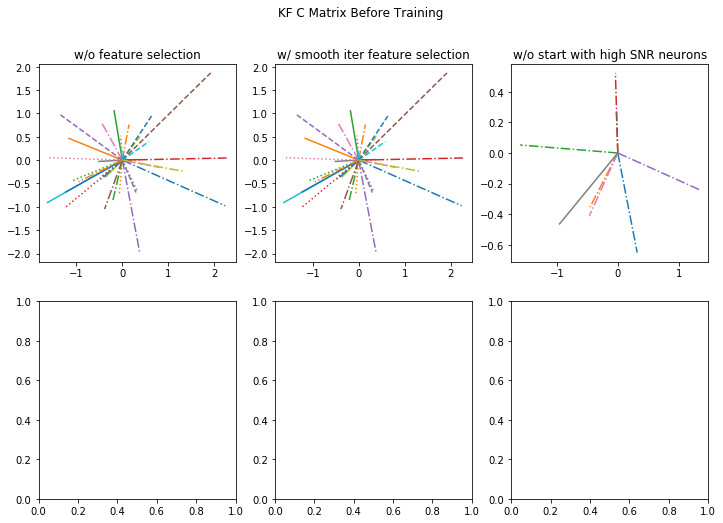

In [21]:
print('we check the new decoder C matrix:')

figure_decoder_C, axs_decoder_C = plt.subplots(nrows=2, 
                               ncols=NUM_EXP, figsize = [GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP, GLOBAL_FIGURE_VERTICAL_SIZE * 2],squeeze = False)
figure_decoder_C.suptitle('KF C Matrix Before Training ')

for i,e in enumerate(exps):
    C = e.decoder.filt.C
    plot_prefered_directions(C, ax = axs_decoder_C[0,i])
    axs_decoder_C[0,i].set_title(exp_conds[i])

# Experiment run: assemble into a complete loop

## actually running the experiments

In [22]:
from feature_selection_feature import run_exp_loop
for i,e in enumerate(exps):
    np.random.seed(0)
    run_exp_loop(e, **kwargs_exps[i])
    print(f'Finished running  {exp_conds[i]}')
    print()
    print()

runseq
finished: 1
assist_level at final value after 0 successful trials


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/bmi/kfdecoder.py:372: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C = np.mat(np.linalg.lstsq(X.T, Y.T)[0].T)


exit
end of FSM.run, task state is None
Finished running  w/o feature selection


runseq
finished: 1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
decoder changes here at 2399
select_decoder_features: _change_one_flag = False
(32, 7)
(32, 7)
active feature set is [False  True False False False False False False False False False False
 False False False False False  True False False False False False False
  True  True False False  True  True  True  True]
after trans: (8, 7)
after trans: (8, 8)
decoder change flag to false
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
decoder changes here at 2999
select_decoder_features: _change_one_flag = False
(8, 7)
(8, 7)
active feature set is [False False False False False False False False False False False False
  True False False False  True  True False False False False  True False
  True  True False False False False  True  True]
after tr

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
decoder changes here at 12599
select_decoder_features: _change_one_flag = False
(8, 7)
(8, 7)
active feature set is [False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True  True  True  True  True  True]
after trans: (8, 7)
after trans: (8, 8)
decoder change flag to false
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
decoder changes here at 13199
select_decoder_features: _change_one_flag = False
(8, 7)
(8, 7)
active feature set is [False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True  True  True  True  True  True]
after trans: (8, 7)
after trans: (8, 8)
decoder change flag to false
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
decoder changes here at 23399
select_decoder_features: _change_one_flag = False
(8, 7)
(8, 7)
active feature set is [False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True  True  True  True  True  True]
after trans: (8, 7)
after trans: (8, 8)
decoder change flag to false
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
decoder changes here at 23999
select_decoder_features: _change_one_flag = False
(8, 7)
(8, 7)
active feature set is [False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True  True  True  True  True  True]
after trans: (8, 7)
after trans: (8, 8)
decoder change flag to false
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
decoder changes here at 34199
select_decoder_features: _change_one_flag = False
(8, 7)
(8, 7)
active feature set is [False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True  True  True  True  True  True]
after trans: (8, 7)
after trans: (8, 8)
decoder change flag to false
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
decoder changes here at 34799
select_decoder_features: _change_one_flag = False
(8, 7)
(8, 7)
active feature set is [False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True  True  True  True  True  True]
after trans: (8, 7)
after trans: (8, 8)
decoder change flag to false
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

# Postprocessing the data for loading

## declare defs and conventions

In [23]:
from feature_selection_feature import *


## Refactor out the data

In [24]:
task_data_hist_np_all = [np.array(e.task_data_hist) for e in exps]
len(task_data_hist_np_all)
task_data_hist_np_all[0].dtype

dtype([('cursor', '<f8', (3,)), ('obs_t', '<f8', (32, 1)), ('KC', '<f8', (7, 7)), ('pred_state_mean', '<f8', (7, 1)), ('post_state_mean', '<f8', (7, 1)), ('pred_state_P', '<f8', (7, 7)), ('post_state_P', '<f8', (7, 7)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (32, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

## Finished time in seconds

# Post data analysis

In [25]:
import seaborn as sns


## Total finished trials

In [26]:
#calculate how many trials
for e in  exps: print(e.calc_state_occurrences('reward'))
print()

for e in  exps: print(e.calc_trial_num())

103
83
93

128
111
121


## Overall  trial statistics succuss rate)

[[1. 2. 6. 3. 5. 6. 4. 5. 3. 7. 6. 7. 6. 7. 7. 6. 8. 4. 5.]
 [1. 3. 2. 5. 4. 3. 3. 4. 3. 4. 7. 6. 3. 5. 5. 4. 6. 3. 8.]
 [0. 1. 4. 6. 3. 6. 7. 6. 6. 4. 4. 6. 4. 6. 5. 4. 6. 5. 5.]]


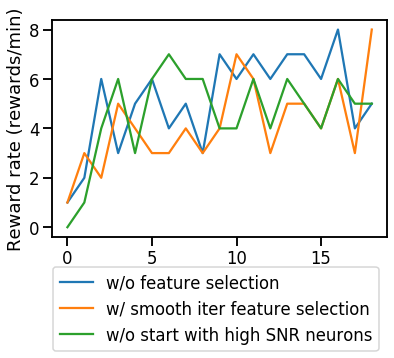

In [41]:
import behaviour_metrics
import importlib

sns.set_context(context = 'talk')
importlib.reload(behaviour_metrics)

reward_events_per_minute = [behaviour_metrics.calc_event_rate_from_state_log(e.state_log,'reward',window_length=30) for e in exps]
reward_events_per_minute = np.array(reward_events_per_minute)

print(reward_events_per_minute)
plt.plot(reward_events_per_minute.T)
plt.ylabel('Reward rate (rewards/min)')
plt.legend(exp_conds, bbox_to_anchor=(1, -0.1))

## sort into trials

In [28]:
state_log = e.state_log
segmented_trials = behaviour_metrics.segment_trials_in_state_log(state_log)

In [29]:
trial_dicts_all = []
dict_keys = ['cursor', #behaviour
             'ctrl_input', 'spike_counts', #encoder translates intended ctrl into spike counts
             'decoder_state']


for i in range(NUM_EXP):
    
    segmented_trials = behaviour_metrics.segment_trials_in_state_log(exps[i].state_log)

    task_data_hist_np = task_data_hist_np_all[i]
    trial_dict_0 = behaviour_metrics.sort_trials_use_segmented_log(segmented_trials, 
                               target_seq,
                               task_data_hist_np, dict_keys)
    
    trial_dicts_all.append(trial_dict_0)

for t in trial_dicts_all: print(len(t))

128
111
121


# Behaviour  analyses

## Trajectory analysis

In [30]:
import afs_plotting
importlib.reload(afs_plotting)

<module 'afs_plotting' from '/home/sijia-aw/BMi3D_my/operation_funny_chicken/adaptive_feature_selection/afs_plotting.py'>

2


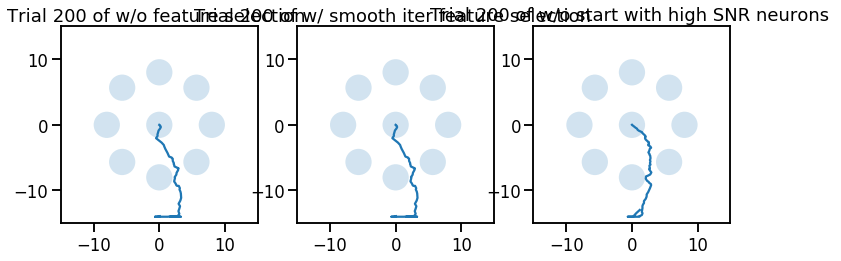

In [31]:
figure_trajectory, axes_trajectory = plt.subplots(1, NUM_EXP, figsize = (NUM_EXP * GLOBAL_FIGURE_VERTICAL_SIZE, 
                                                  GLOBAL_FIGURE_VERTICAL_SIZE)) 


n_roi_trials = 0

CIRCLE_RADIUS = exps[0].target_radius

print(CIRCLE_RADIUS)

for i,axes in enumerate(axes_trajectory): 

    afs_plotting.add_center_out_grid(axes, target_seq, CIRCLE_RADIUS)
    
    
    sample_trial = trial_dicts_all[i][n_roi_trials]
    trial_cursor_trajectory = sample_trial['cursor']
    
    afs_plotting.plot_trial_trajectory(axes, trial_cursor_trajectory)

    axes.set_title(f'Trial {N_TRIALS} of {exp_conds[i]} ')



## Variance analysis

In [32]:
importlib.reload(behaviour_metrics)

<module 'behaviour_metrics' from '/home/sijia-aw/BMi3D_my/operation_funny_chicken/adaptive_feature_selection/behaviour_metrics.py'>

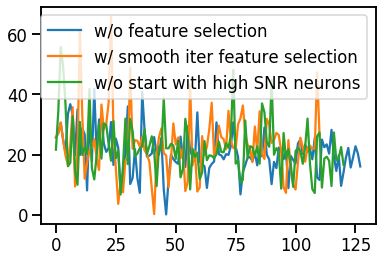

In [33]:
arc_length = [behaviour_metrics.calc_arc_length_from_trial_dict(trial_dict) for trial_dict in trial_dicts_all]
for al in arc_length: plt.plot(al)
plt.legend(exp_conds)

# Kalman filter

## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

## decoder

steady state tuning curves:


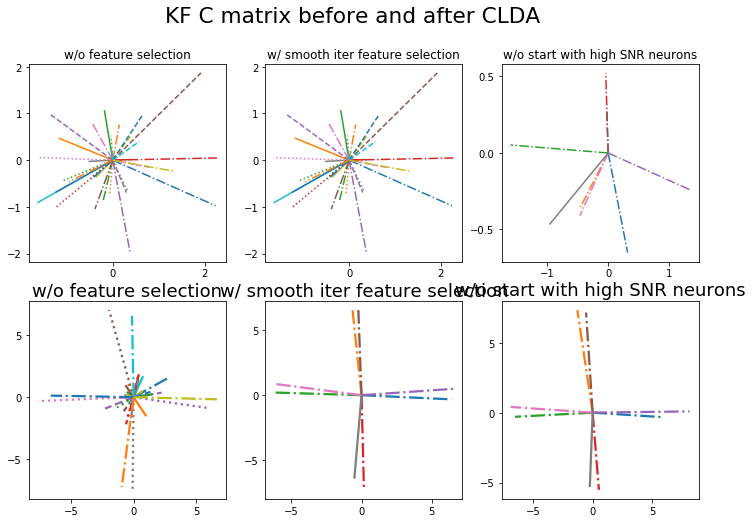

In [34]:
from afs_plotting import plot_prefered_directions

TEXT_OFFSET_VERTICAL = -0.2


figure_decoder_C.suptitle('KF C matrix before and after CLDA')

print('steady state tuning curves:')

for  i,e in enumerate(exps): 

    e = exps[i]
    C = e.decoder.filt.C

    plot_prefered_directions(C, ax = axs_decoder_C[1,i])
    axs_decoder_C[1,i].set_title(f'{exp_conds[i]}')

figure_decoder_C

## Decoder compared to the encoder



In [35]:
len(exps)

3

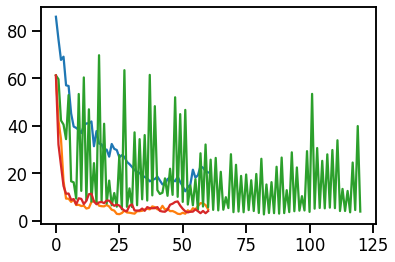

In [36]:
import convergence_analysis
importlib.reload(convergence_analysis)
from convergence_analysis import calc_cosine_sim_bet_two_matrices, calc_cosine_to_target_matrix

active_feat_set = exps[2]._active_feat_set


for i,e in enumerate(exps):
    enc_directions = e.encoder.C
    dec_directions = np.array(e._used_C_mat_list)
    

    angles_hist = calc_cosine_to_target_matrix( dec_directions,enc_directions)
    
    if i == 0:
        active_angles = np.mean(angles_hist[:,noise_neuron_list], axis = 1)
        plt.plot(active_angles)
    
    active_angles = np.mean(angles_hist[:,active_feat_set], axis = 1)
    plt.plot(active_angles)
    


## looking at K matrix

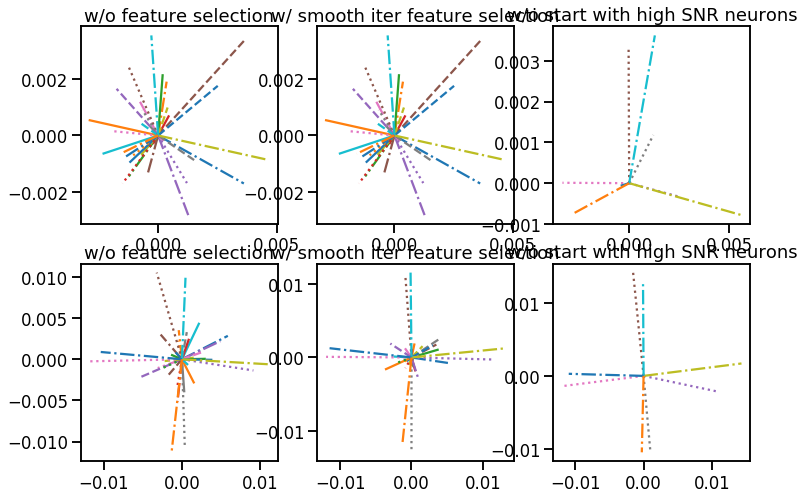

In [37]:
figure_k_matrix, axes_k_matrix = plt.subplots(2,NUM_EXP,
                                          figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP,
                                                    GLOBAL_FIGURE_VERTICAL_SIZE * 2))

for i,e in enumerate(exps):
    K = (e._used_K_mat_list[1]).T

    plot_prefered_directions(K, ax  = axes_k_matrix[0, i])
    axes_k_matrix[0, i].set_title(exp_conds[i])

for i,e in enumerate(exps):
    K = (e._used_K_mat_list[-1]).T
    plot_prefered_directions(K, ax  = axes_k_matrix[1, i])
    axes_k_matrix[1,i].set_title(exp_conds[i])

# Feature analysis

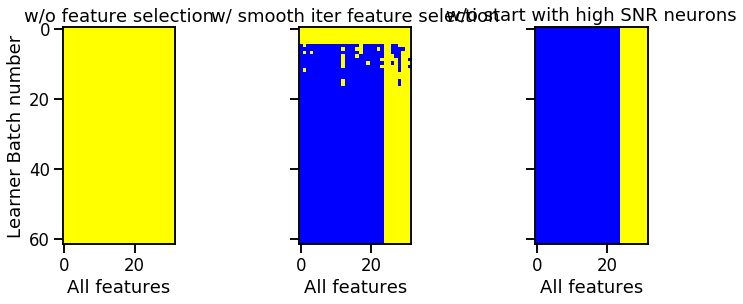

In [38]:
from matplotlib import colors



fig_feature_active_map, axes_feat_active_map = plt.subplots(1, NUM_EXP,
                                                            figsize = ( NUM_EXP * GLOBAL_FIGURE_VERTICAL_SIZE,
                                                                      GLOBAL_FIGURE_VERTICAL_SIZE),
                                                           sharey = True)
axes_feat_active_map[0].set_ylabel('Learner Batch number')

#color true to yellow
cmap = colors.ListedColormap(['yellow'])

for i, exp in enumerate(exps):

    active_feat_heat_map = np.array(exp._active_feat_set_list, dtype = np.int32)
    active_feat_heat_map = np.ma.masked_where(active_feat_heat_map == False, active_feat_heat_map)
    a = axes_feat_active_map[i].imshow(active_feat_heat_map, cmap = cmap)

    #color false to blue
    cmap.set_bad(color='blue')
    
    axes_feat_active_map[i].set_xlabel('All features')
    axes_feat_active_map[i].set_title(exp_conds[i])


#fig_feature_active_map.colorbar(a, ax=axes_feat_active_map.ravel().tolist())

## Examine used K mat

## examine used C mat

(32, 7)
(32, 7)
(32, 7)


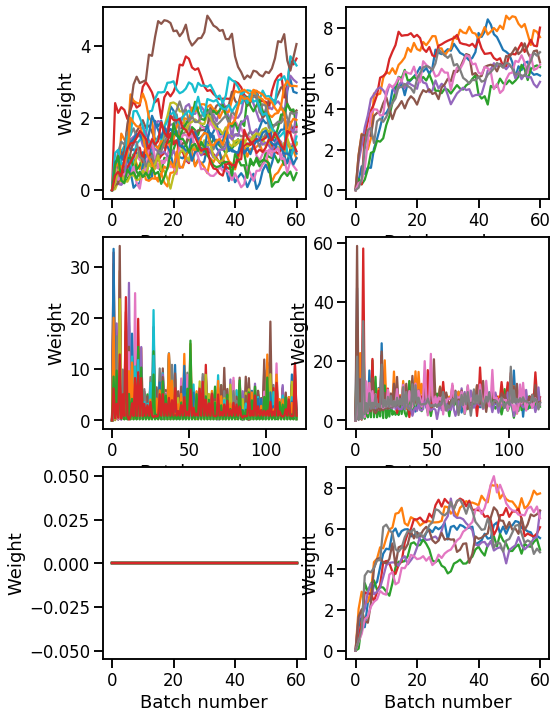

In [39]:
import weights_linear_regression
importlib.reload(weights_linear_regression)
from weights_linear_regression import calc_a_history_of_matrix_L2norms_along_first_axis


figure_weights_norm, axes_weights_norm = plt.subplots( NUM_EXP, N_TYPES_OF_NEURONS,
    figsize = (N_TYPES_OF_NEURONS * GLOBAL_FIGURE_VERTICAL_SIZE, NUM_EXP * GLOBAL_FIGURE_VERTICAL_SIZE))

C_mat_all = list()

for j,exp in enumerate(exps):
    
    updated_C_mat = np.array(exp._used_C_mat_list)
    the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(updated_C_mat, debug = False)

    C_mat_all.append(np.copy(updated_C_mat))
    axe_exp = axes_weights_norm[j,:]
    for i,a in enumerate(axe_exp):
        a.plot(the_history_of_KF_weights_in_time_by_neurons[:, neuron_type_indices_in_a_list[i]])
        a.set_xlabel('Batch number')
        a.set_ylabel('Weight')
        
C_mat_all = np.array(C_mat_all)

/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/sijia-aw/BMi3D_my/lib/python3.8/site-packages/numpy/core/_methods.py:206: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


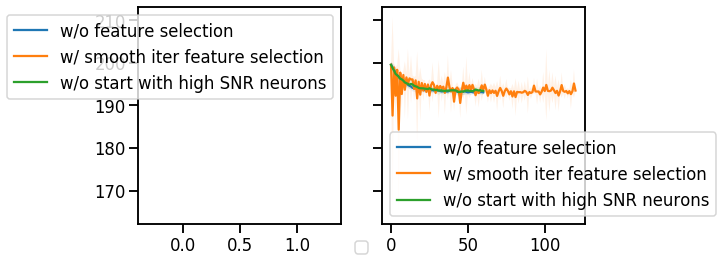

In [40]:
fig_compr_means, axes_compr_means = plt.subplots(1, N_TYPES_OF_NEURONS,
                                                figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * N_TYPES_OF_NEURONS,
                                                          GLOBAL_FIGURE_VERTICAL_SIZE),
                                                sharey = True)
selected_feature_set = no_noise_neuron_list
for i,a in enumerate(axes_compr_means):

    type_neuron_list = neuron_type_bool_list[i]
    
    for C in C_mat_all:


        the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(C, 
                                                                                                         target_C=e.encoder.C,
                                                                indices_to_sum=(X_VEL_STATE_IND, Y_VEL_STATE_IND))


        selected_neurons = np.logical_and(selected_feature_set, type_neuron_list)

        selected_mean = np.mean(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        std = np.std(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        
        line = a.plot(selected_mean)
        
        x_data = np.arange((selected_mean).shape[0])
        
        
        a.fill_between(x_data ,selected_mean - std, selected_mean + std, alpha = 0.1 )
        a.legend(exp_conds)
        
handles, labels = a.get_legend_handles_labels()
fig_compr_means.legend(handles, labels, loc='lower center')
plt.show()
    
#axes_compr_means.set_title('Means of the high SNR weight trajectory')